In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats

# Configuración
plt.style.use('seaborn-v0_8-whitegrid')
pd.set_option('display.max_columns', 50)

# Rutas
BASE_DIR = Path().resolve().parent
DATA_PATH = BASE_DIR / 'data' / 'gold' / 'model' / 'regression_annual_dataset.parquet'

In [2]:
# Cargar datos
df = pd.read_parquet(DATA_PATH)
print(f"Shape: {df.shape}")
print(f"\nColumnas: {df.columns.tolist()}")
df.head()

Shape: (1387, 26)

Columnas: ['codigo_municipio', 'anio', 'poblacion_total', 'poblacion_menores', 'poblacion_adultos', 'poblacion_adolescentes', 'area_km2', 'densidad_poblacional', 'centros_por_km2', 'total_delitos', 'ABIGEATO', 'HURTOS', 'LESIONES', 'VIOLENCIA INTRAFAMILIAR', 'AMENAZAS', 'DELITOS SEXUALES', 'EXTORSION', 'HOMICIDIOS', 'tasa_abigeato', 'tasa_hurtos', 'tasa_lesiones', 'tasa_violencia intrafamiliar', 'tasa_amenazas', 'tasa_delitos sexuales', 'tasa_extorsion', 'tasa_homicidios']


,codigo_municipio,anio,poblacion_total,poblacion_menores,poblacion_adultos,poblacion_adolescentes,area_km2,densidad_poblacional,centros_por_km2,total_delitos,ABIGEATO,HURTOS,LESIONES,VIOLENCIA INTRAFAMILIAR,AMENAZAS,DELITOS SEXUALES,EXTORSION,HOMICIDIOS,tasa_abigeato,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios
0,68001,2010,1048060.0,122333.0,879556.0,46171.0,152.915686,6853.842316,0.00654,5995,2,303,3814,1002,360,319,27,168,0.190829,28.910559,363.910463,95.605213,34.349178,30.437189,2.576188,16.029617
1,68001,2011,1050238.0,120475.0,884052.0,45711.0,152.915686,6868.085459,0.00654,10095,0,3032,4590,1529,378,389,17,160,0.000000,288.696467,437.043794,145.586048,35.991842,37.039223,1.618681,15.234642
2,68001,2012,1052112.0,118590.0,888231.0,45291.0,152.915686,6880.340579,0.00654,10793,0,3417,4750,1530,441,462,36,157,0.000000,324.775309,451.472847,145.421780,41.915690,43.911675,3.421689,14.922366
3,68001,2013,1053654.0,116697.0,892060.0,44897.0,152.915686,6890.424567,0.00654,10593,0,3353,4641,1443,510,435,45,166,0.000000,318.225907,440.467174,136.951979,48.402986,41.284900,4.270852,15.754697
4,68001,2014,1054902.0,114813.0,895621.0,44468.0,152.915686,6898.585927,0.00654,10110,2,3032,4175,1879,499,328,53,142,0.189591,287.420064,395.771361,178.120811,47.302972,31.092936,5.024163,13.460966


In [3]:
# Info general
print("=" * 60)
print("INFO GENERAL")
print("=" * 60)
print(f"\nTotal registros: {len(df):,}")
print(f"Período: {df['anio'].min()} - {df['anio'].max()}")
print(f"Municipios: {df['codigo_municipio'].nunique()}")
print(f"\nValores nulos:")
nulls = df.isnull().sum()
print(nulls[nulls > 0] if any(nulls > 0) else "Ninguno")

INFO GENERAL

Total registros: 1,387
Período: 2010 - 2025
Municipios: 87

Valores nulos:
Ninguno


## 1. Distribución de Targets

In [4]:
# Identificar targets (columnas de tasas + total_delitos)
target_cols = ['total_delitos'] + [c for c in df.columns if c.startswith('tasa_')]
print("Targets identificados:")
for t in target_cols:
    print(f"  - {t}")

# Estadísticas de targets
print("\n" + "=" * 60)
print("ESTADÍSTICAS DE TARGETS")
print("=" * 60)
df[target_cols].describe().round(2)

Targets identificados:
  - total_delitos
  - tasa_abigeato
  - tasa_hurtos
  - tasa_lesiones
  - tasa_violencia intrafamiliar
  - tasa_amenazas
  - tasa_delitos sexuales
  - tasa_extorsion
  - tasa_homicidios

ESTADÍSTICAS DE TARGETS


,total_delitos,tasa_abigeato,tasa_hurtos,tasa_lesiones,tasa_violencia intrafamiliar,tasa_amenazas,tasa_delitos sexuales,tasa_extorsion,tasa_homicidios
count,1387.00,1387.00,1387.00,1387.00,1387.00,1387.00,1387.00,1387.00,1387.00
mean,347.66,5.26,85.84,203.51,114.73,74.13,47.48,4.05,16.04
std,1423.35,12.85,134.69,177.60,125.02,92.13,48.87,10.65,23.21
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,15.00,0.00,11.56,79.12,28.95,19.28,16.63,0.00,0.00
50%,33.00,0.00,45.61,156.79,75.33,46.77,36.59,0.00,9.17
75%,90.50,4.28,105.37,273.66,157.61,95.13,66.11,3.40,22.41
max,17940.00,149.94,1590.93,1674.72,838.18,1524.43,549.79,141.91,186.74


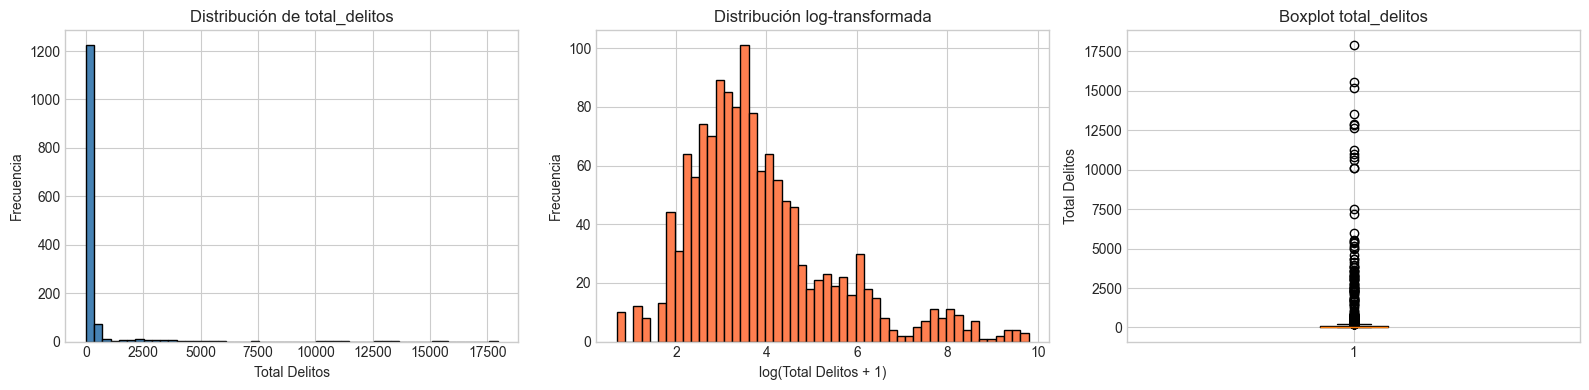


Test de normalidad (D'Agostino): p-value = 0.00e+00
⚠️ Distribución NO normal

Recomendación: Considerar log-transform o modelos robustos a outliers


In [5]:
# Distribución de total_delitos
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Histograma
axes[0].hist(df['total_delitos'], bins=50, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Total Delitos')
axes[0].set_ylabel('Frecuencia')
axes[0].set_title('Distribución de total_delitos')

# Log-transform
df_log = np.log1p(df['total_delitos'])
axes[1].hist(df_log, bins=50, color='coral', edgecolor='black')
axes[1].set_xlabel('log(Total Delitos + 1)')
axes[1].set_ylabel('Frecuencia')
axes[1].set_title('Distribución log-transformada')

# Boxplot
axes[2].boxplot(df['total_delitos'].dropna())
axes[2].set_ylabel('Total Delitos')
axes[2].set_title('Boxplot total_delitos')

plt.tight_layout()
plt.show()

# Test de normalidad
_, p_value = stats.normaltest(df['total_delitos'].dropna())
print(f"\nTest de normalidad (D'Agostino): p-value = {p_value:.2e}")
print("⚠️ Distribución NO normal" if p_value < 0.05 else "✅ Distribución aproximadamente normal")
print("\nRecomendación: Considerar log-transform o modelos robustos a outliers")

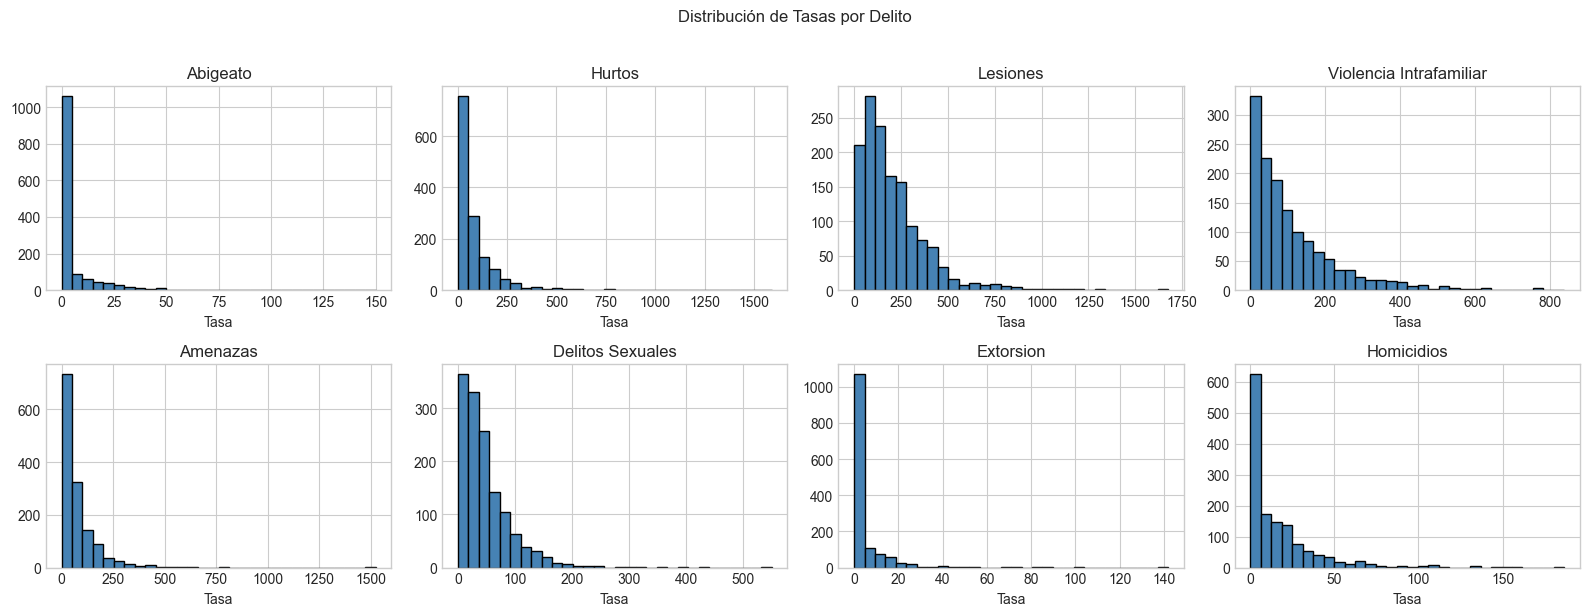

In [6]:
# Distribución de tasas
tasa_cols = [c for c in df.columns if c.startswith('tasa_')]

if tasa_cols:
    n_cols = min(4, len(tasa_cols))
    n_rows = (len(tasa_cols) + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    axes = axes.flat if n_rows > 1 or n_cols > 1 else [axes]
    
    for ax, col in zip(axes, tasa_cols):
        df[col].hist(bins=30, ax=ax, color='steelblue', edgecolor='black')
        ax.set_title(col.replace('tasa_', '').title())
        ax.set_xlabel('Tasa')
    
    # Ocultar ejes vacíos
    for ax in axes[len(tasa_cols):]:
        ax.set_visible(False)
    
    plt.suptitle('Distribución de Tasas por Delito', y=1.02)
    plt.tight_layout()
    plt.show()

## 2. Análisis Temporal

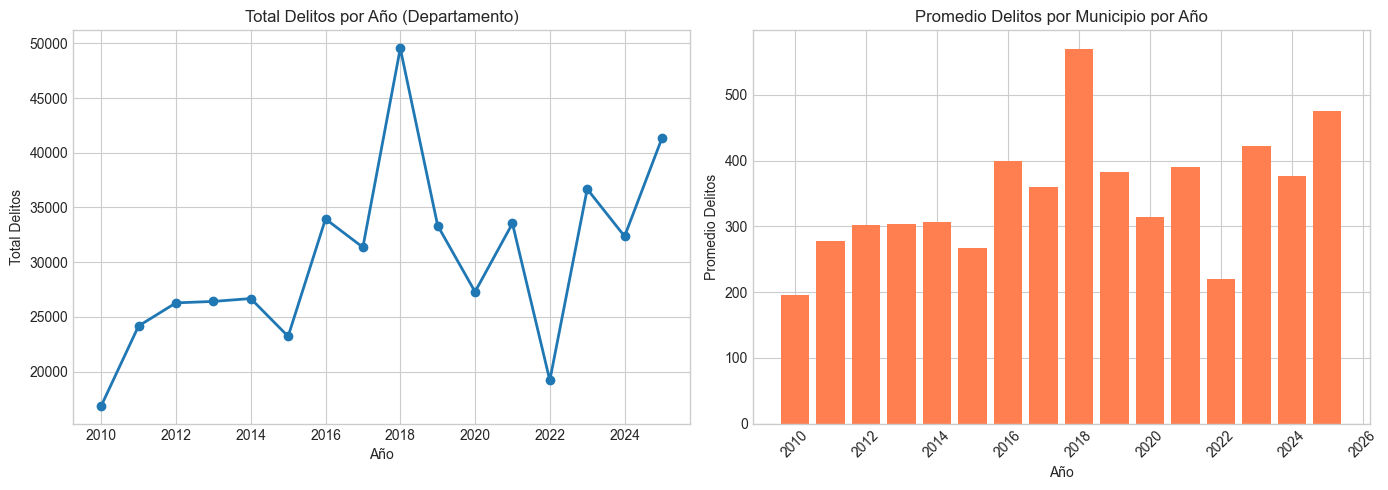

In [7]:
# Evolución temporal de delitos
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total delitos por año
delitos_por_anio = df.groupby('anio')['total_delitos'].sum()
axes[0].plot(delitos_por_anio.index, delitos_por_anio.values, marker='o', linewidth=2)
axes[0].set_xlabel('Año')
axes[0].set_ylabel('Total Delitos')
axes[0].set_title('Total Delitos por Año (Departamento)')
axes[0].grid(True)

# Promedio por municipio por año
promedio_por_anio = df.groupby('anio')['total_delitos'].mean()
axes[1].bar(promedio_por_anio.index, promedio_por_anio.values, color='coral')
axes[1].set_xlabel('Año')
axes[1].set_ylabel('Promedio Delitos')
axes[1].set_title('Promedio Delitos por Municipio por Año')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Correlaciones

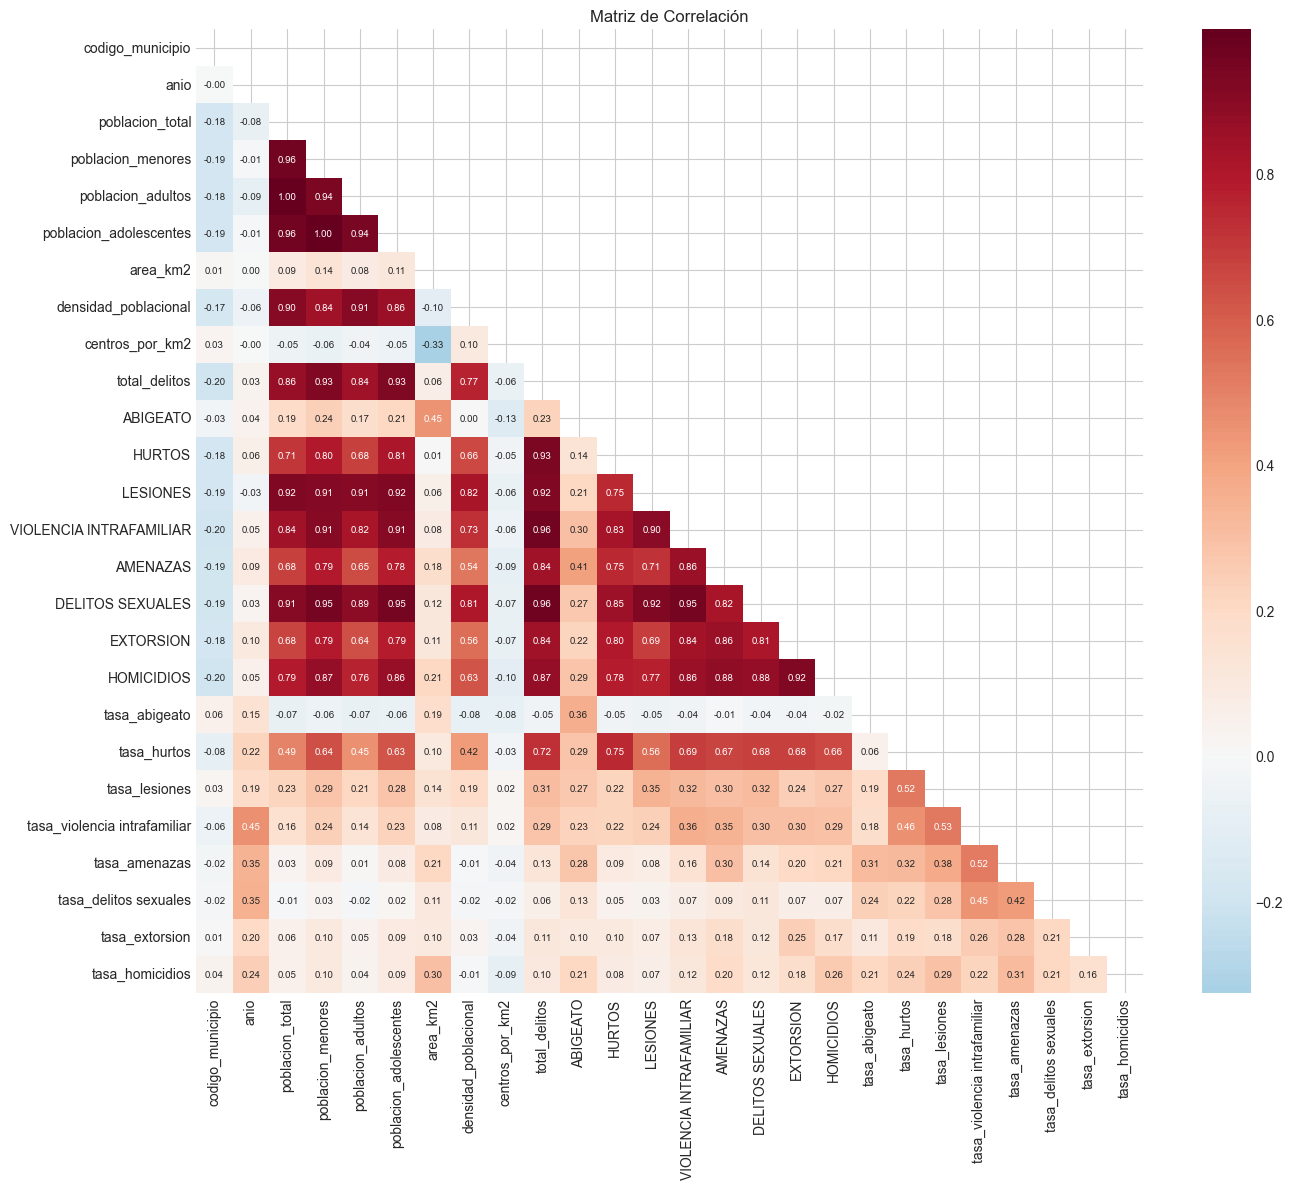

In [8]:
# Seleccionar features numéricas
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()

# Matriz de correlación
fig, ax = plt.subplots(figsize=(14, 12))
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='RdBu_r', 
            center=0, ax=ax, annot_kws={'size': 7})
ax.set_title('Matriz de Correlación')
plt.tight_layout()
plt.show()

In [9]:
# Correlaciones con total_delitos
print("=" * 60)
print("CORRELACIONES CON total_delitos")
print("=" * 60)

corr_target = df[numeric_cols].corr()['total_delitos'].drop('total_delitos').sort_values(ascending=False)
print("\nTop 10 correlaciones positivas:")
print(corr_target.head(10).round(3))
print("\nTop 10 correlaciones negativas:")
print(corr_target.tail(10).round(3))

CORRELACIONES CON total_delitos

Top 10 correlaciones positivas:
DELITOS SEXUALES           0.964
VIOLENCIA INTRAFAMILIAR    0.958
HURTOS                     0.934
poblacion_adolescentes     0.930
poblacion_menores          0.925
LESIONES                   0.921
HOMICIDIOS                 0.872
poblacion_total            0.864
AMENAZAS                   0.842
EXTORSION                  0.840
Name: total_delitos, dtype: float64

Top 10 correlaciones negativas:
ABIGEATO                 0.232
tasa_amenazas            0.128
tasa_extorsion           0.113
tasa_homicidios          0.105
area_km2                 0.063
tasa_delitos sexuales    0.058
anio                     0.033
tasa_abigeato           -0.045
centros_por_km2         -0.064
codigo_municipio        -0.199
Name: total_delitos, dtype: float64


## 4. Análisis de Outliers

In [10]:
# Detección de outliers con IQR
print("=" * 60)
print("ANÁLISIS DE OUTLIERS (total_delitos)")
print("=" * 60)

Q1 = df['total_delitos'].quantile(0.25)
Q3 = df['total_delitos'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df['total_delitos'] < lower_bound) | (df['total_delitos'] > upper_bound)]

print(f"\nQ1: {Q1:.0f}")
print(f"Q3: {Q3:.0f}")
print(f"IQR: {IQR:.0f}")
print(f"Límite inferior: {lower_bound:.0f}")
print(f"Límite superior: {upper_bound:.0f}")
print(f"\nOutliers detectados: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")

if len(outliers) > 0:
    print(f"\nTop 10 outliers:")
    cols_show = ['codigo_municipio', 'anio', 'total_delitos', 'poblacion_total']
    cols_show = [c for c in cols_show if c in df.columns]
    print(outliers.nlargest(10, 'total_delitos')[cols_show])

ANÁLISIS DE OUTLIERS (total_delitos)

Q1: 15
Q3: 90
IQR: 76
Límite inferior: -98
Límite superior: 204

Outliers detectados: 227 (16.4%)

Top 10 outliers:
    codigo_municipio  anio  total_delitos  poblacion_total
8              68001  2018          17940         581130.0
15             68001  2025          15534         623881.0
13             68001  2023          15199         614860.0
11             68001  2021          13528         604462.0
6              68001  2016          12922        1056538.0
9              68001  2019          12852         595635.0
14             68001  2024          12671         619703.0
7              68001  2017          11230        1056994.0
10             68001  2020          11013         600098.0
2              68001  2012          10793        1052112.0


## 5. Conclusiones y Recomendaciones

In [11]:
print("=" * 60)
print("CONCLUSIONES")
print("=" * 60)

skewness = df['total_delitos'].skew()
kurtosis = df['total_delitos'].kurtosis()

print(f"""
DISTRIBUCIÓN DEL TARGET (total_delitos):
  - Media: {df['total_delitos'].mean():.0f}
  - Mediana: {df['total_delitos'].median():.0f}
  - Std: {df['total_delitos'].std():.0f}
  - Skewness: {skewness:.2f} ({'Alta asimetría positiva' if skewness > 1 else 'Moderada'})
  - Kurtosis: {kurtosis:.2f}
  - Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)

DATASET:
  - Registros: {len(df):,}
  - Features: {len(df.columns)}
  - Período: {df['anio'].min()} - {df['anio'].max()}
""")

print("\n" + "=" * 60)
print("RECOMENDACIONES PARA MODELO")
print("=" * 60)
print("""
1. TRANSFORMACIÓN DEL TARGET:
   - Aplicar log-transform: y = log(total_delitos + 1)
   - O usar modelos robustos a outliers

2. MODELOS SUGERIDOS:
   - XGBoost / LightGBM (robustos a outliers)
   - Random Forest
   - Elastic Net (si se normaliza)

3. MÉTRICAS:
   - RMSE, MAE (en escala original)
   - MAPE para interpretabilidad
   - R² para varianza explicada

4. VALIDACIÓN:
   - TimeSeriesSplit por año
   - O GroupKFold por municipio

5. FEATURES:
   - Lag features del año anterior
   - Tendencia temporal
   - Interacciones población × área
""")

CONCLUSIONES

DISTRIBUCIÓN DEL TARGET (total_delitos):
  - Media: 348
  - Mediana: 33
  - Std: 1423
  - Skewness: 7.42 (Alta asimetría positiva)
  - Kurtosis: 64.38
  - Outliers: 227 (16.4%)

DATASET:
  - Registros: 1,387
  - Features: 26
  - Período: 2010 - 2025


RECOMENDACIONES PARA MODELO

1. TRANSFORMACIÓN DEL TARGET:
   - Aplicar log-transform: y = log(total_delitos + 1)
   - O usar modelos robustos a outliers

2. MODELOS SUGERIDOS:
   - XGBoost / LightGBM (robustos a outliers)
   - Random Forest
   - Elastic Net (si se normaliza)

3. MÉTRICAS:
   - RMSE, MAE (en escala original)
   - MAPE para interpretabilidad
   - R² para varianza explicada

4. VALIDACIÓN:
   - TimeSeriesSplit por año
   - O GroupKFold por municipio

5. FEATURES:
   - Lag features del año anterior
   - Tendencia temporal
   - Interacciones población × área



## 6. Transformación de Targets

In [12]:
# Crear dataset con targets transformados
print("=" * 60)
print("TRANSFORMACIÓN DE TARGETS")
print("=" * 60)

df_transformed = df.copy()

# Log-transform para total_delitos
df_transformed['total_delitos_log'] = np.log1p(df['total_delitos'])

# Log-transform para tasas
tasa_cols = [c for c in df.columns if c.startswith('tasa_')]
for col in tasa_cols:
    df_transformed[f'{col}_log'] = np.log1p(df[col])

print(f"\nTransformaciones aplicadas:")
print(f"  - total_delitos → total_delitos_log")
for col in tasa_cols:
    print(f"  - {col} → {col}_log")

# Comparación antes vs después
print("\n" + "-" * 60)
print("COMPARACIÓN: ORIGINAL vs LOG-TRANSFORMADO")
print("-" * 60)

comparison_data = {
    'Variable': ['total_delitos'] + tasa_cols,
    'Original_Skewness': [df['total_delitos'].skew()] + [df[col].skew() for col in tasa_cols],
    'Log_Skewness': [df_transformed['total_delitos_log'].skew()] + 
                    [df_transformed[f'{col}_log'].skew() for col in tasa_cols],
    'Mejora': ['↓' if df_transformed['total_delitos_log'].skew() < df['total_delitos'].skew() else '↑'] +
             ['↓' if df_transformed[f'{col}_log'].skew() < df[col].skew() else '↑' for col in tasa_cols]
}

comparison_df = pd.DataFrame(comparison_data).round(3)
print(comparison_df)

TRANSFORMACIÓN DE TARGETS

Transformaciones aplicadas:
  - total_delitos → total_delitos_log
  - tasa_abigeato → tasa_abigeato_log
  - tasa_hurtos → tasa_hurtos_log
  - tasa_lesiones → tasa_lesiones_log
  - tasa_violencia intrafamiliar → tasa_violencia intrafamiliar_log
  - tasa_amenazas → tasa_amenazas_log
  - tasa_delitos sexuales → tasa_delitos sexuales_log
  - tasa_extorsion → tasa_extorsion_log
  - tasa_homicidios → tasa_homicidios_log

------------------------------------------------------------
COMPARACIÓN: ORIGINAL vs LOG-TRANSFORMADO
------------------------------------------------------------
                       Variable  Original_Skewness  Log_Skewness Mejora
0                 total_delitos              7.421         1.139      ↓
1                 tasa_abigeato              4.642         1.290      ↓
2                   tasa_hurtos              4.477        -0.703      ↓
3                 tasa_lesiones              2.170        -2.026      ↓
4  tasa_violencia intrafamilia

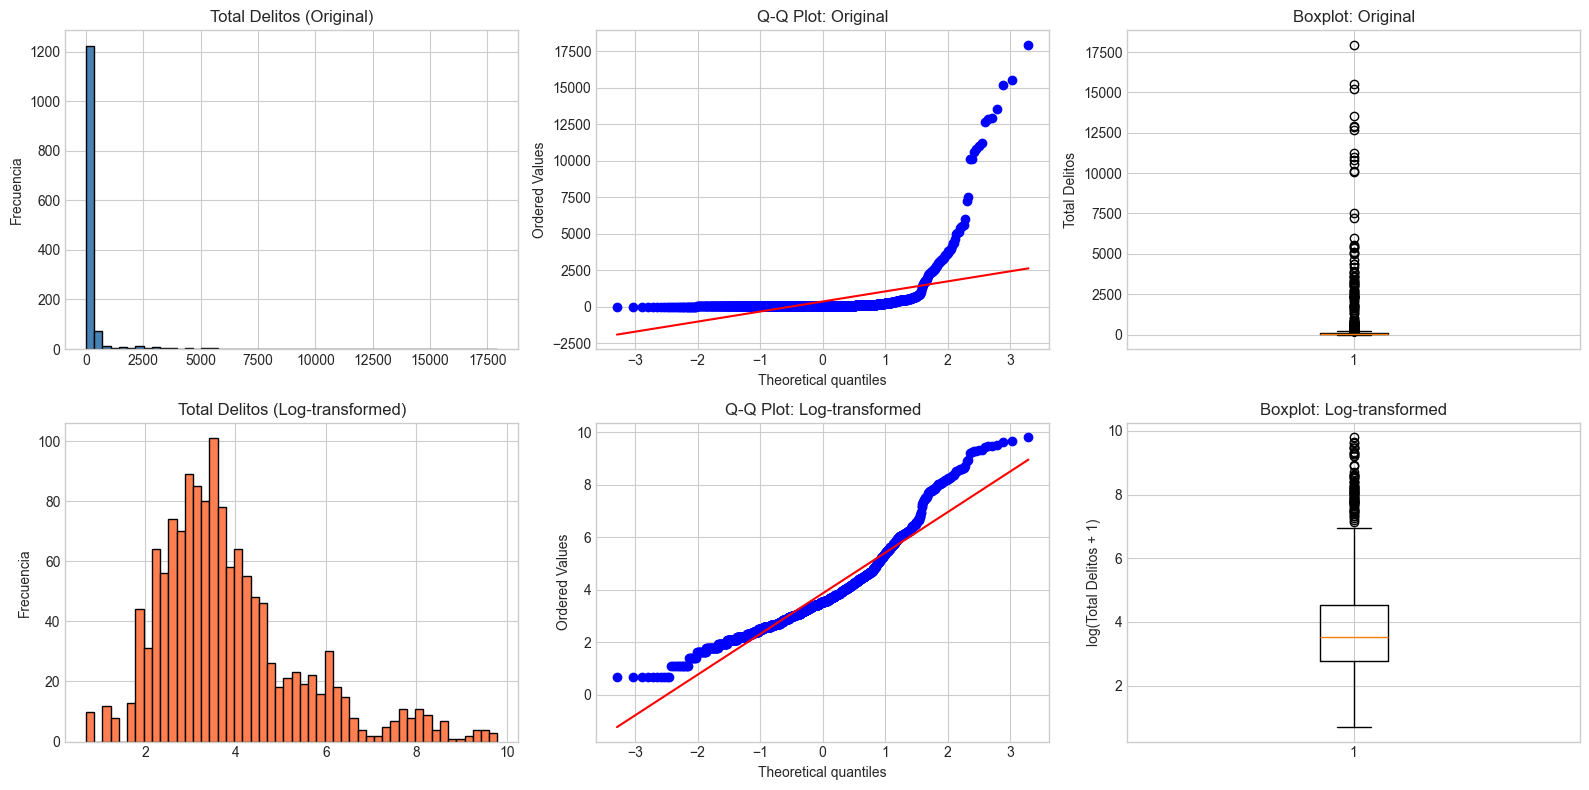


Test de Normalidad (D'Agostino):
  Original:       p-value = 0.00e+00 ❌
  Log-transformed: p-value = 3.27e-54 ❌

Mejora: inf% positiva


C:\Users\57318\AppData\Local\Temp\ipykernel_12748\1372308216.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"\nMejora: {round((p_log - p_orig) / p_orig * 100, 1)}% {'positiva' if p_log > p_orig else 'negativa'}")


In [13]:
# Visualizar transformaciones
fig, axes = plt.subplots(2, 3, figsize=(16, 8))

# Total delitos
axes[0, 0].hist(df['total_delitos'], bins=50, color='steelblue', edgecolor='black')
axes[0, 0].set_title('Total Delitos (Original)')
axes[0, 0].set_ylabel('Frecuencia')

axes[1, 0].hist(df_transformed['total_delitos_log'], bins=50, color='coral', edgecolor='black')
axes[1, 0].set_title('Total Delitos (Log-transformed)')
axes[1, 0].set_ylabel('Frecuencia')

# Q-Q plots para normalidad
from scipy import stats as sp_stats

# Original
sp_stats.probplot(df['total_delitos'].dropna(), dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot: Original')

# Log-transformed
sp_stats.probplot(df_transformed['total_delitos_log'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot: Log-transformed')

# Boxplots
axes[0, 2].boxplot(df['total_delitos'].dropna(), vert=True)
axes[0, 2].set_title('Boxplot: Original')
axes[0, 2].set_ylabel('Total Delitos')

axes[1, 2].boxplot(df_transformed['total_delitos_log'].dropna(), vert=True)
axes[1, 2].set_title('Boxplot: Log-transformed')
axes[1, 2].set_ylabel('log(Total Delitos + 1)')

plt.tight_layout()
plt.show()

# Test de normalidad antes y después
_, p_orig = sp_stats.normaltest(df['total_delitos'].dropna())
_, p_log = sp_stats.normaltest(df_transformed['total_delitos_log'].dropna())

print("\nTest de Normalidad (D'Agostino):")
print(f"  Original:       p-value = {p_orig:.2e} {'✅' if p_orig > 0.05 else '❌'}")
print(f"  Log-transformed: p-value = {p_log:.2e} {'✅' if p_log > 0.05 else '❌'}")
print(f"\nMejora: {round((p_log - p_orig) / p_orig * 100, 1)}% {'positiva' if p_log > p_orig else 'negativa'}")

## 7. Guardar Dataset Transformado

In [14]:
# Ruta para guardar dataset transformado
TRANSFORMED_DATA_PATH = BASE_DIR / 'data' / 'model' / 'regression_annual_dataset_transformed.parquet'

# Crear carpeta si no existe
TRANSFORMED_DATA_PATH.parent.mkdir(parents=True, exist_ok=True)

# Guardar dataset
df_transformed.to_parquet(TRANSFORMED_DATA_PATH, index=False)
print(f"✓ Dataset transformado guardado: {TRANSFORMED_DATA_PATH}")
print(f"  Shape: {df_transformed.shape}")
print(f"\nDataset contiene:")
print(f"  - Targets originales: total_delitos + {len(tasa_cols)} tasas")
print(f"  - Targets transformados (log): total_delitos_log + {len(tasa_cols)} tasas_log")
print(f"\nUso recomendado:")
print(f"  - Para modelos sensibles a distribución: usar targets_log")
print(f"  - Para interpretabilidad: entrenar con log, predecir y transformar inversa")
print(f"  - Para modelos robustos: usar targets originales")

✓ Dataset transformado guardado: C:\Users\57318\Downloads\mintic\Datos-al-Ecosistema\data\model\regression_annual_dataset_transformed.parquet
  Shape: (1387, 35)

Dataset contiene:
  - Targets originales: total_delitos + 8 tasas
  - Targets transformados (log): total_delitos_log + 8 tasas_log

Uso recomendado:
  - Para modelos sensibles a distribución: usar targets_log
  - Para interpretabilidad: entrenar con log, predecir y transformar inversa
  - Para modelos robustos: usar targets originales
